In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf


import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from keras import layers, losses
from keras.models import Sequential
from sklearn import metrics
from tqdm import tqdm
from keras.optimizers import Adam
from keras.layers import InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, LayerNormalization
from keras.models import Model

In [2]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

## Data Loading

In [3]:
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [5]:
# Check the column names
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

## Data Setup

In [6]:
# Get labels from data slow
label_slow = data_slow[:,-1:]
data_slow = data_slow[:,:-1]

In [7]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal)
data_train_scaled = scaler.transform(data_normal)
data_test_scaled = scaler.transform(data_slow) #

In [8]:
#windows of 50 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233744, 48, 86) 
 test data shape: (41490, 48, 86) 


In [9]:
percentage = 0.10
N = 4

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train[-int(data_test.shape[0]):,:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(percentage*data_train_all.shape[0]*N): int(percentage*data_train_all.shape[0]*(N+0.1)),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (23374, 48, 86) 
test data shape: (4149, 48, 86) 
label shape: (4149, 1) 

test data prepared: (8298, 48, 86) 
label prepared: (8298, 1) 

data validation: (2338, 48, 86)


In [10]:
# Run if you want ram free
data_train_all = 0
data_test_all = 0
data_slow = 0
data_normal = 0

## Model

In [11]:
latent_size = 32
input_shape = data_train.shape[1:]
n_features = 86
width_window = 48

In [12]:
class Autoencoder(Model):
  def __init__(self, encoder, decoder, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
def build_model_enc():
    model = Sequential()
    #model.add(LSTM(256, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LayerNormalization())
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LayerNormalization())
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(LayerNormalization())
    model.add(RepeatVector(width_window))
    return model

def build_model_dec():
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LayerNormalization())
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LayerNormalization())
    model.add(LSTM(128, activation='relu', return_sequences=True))
    #model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    return model

def build_model_disc():
    model = Sequential()
    model.add(layers.Dense(256, activation="relu", input_shape=(width_window, latent_size)))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

# To be sure model have the ability to reconstruct timeseries

In [16]:
model_enc = build_model_enc()
model_dec = build_model_dec()

model = Sequential()
model.add(model_enc)
model.add(model_dec)

learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)

tf.debugging.set_log_device_placement(True)
try:
    with tf.device('/GPU'):
        data_train = tf.convert_to_tensor(data_train, dtype=tf.float32)
        model = model
        model.compile(optimizer=optimizer, loss='mse')
        model.summary()
except RuntimeError as e:
    print(e)
history = model.fit(data_train, data_train, epochs=20, batch_size=128,validation_data=(data_validation, data_validation), shuffle=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 48, 32)            172352    
                                                                 
 sequential_4 (Sequential)   (None, 48, 86)            143254    
                                                                 
Total params: 315,606
Trainable params: 315,606
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2023-06-19 16:29:15.687478: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


183/183 [==============================] - 52s 267ms/step - loss: 0.9756 - val_loss: 1.2362
Epoch 2/20
 10/183 [>.............................] - ETA: 46s - loss: 1.1062

KeyboardInterrupt: 

In [183]:
p_train = model.predict(data_train)
difference_train = np.abs(p_train - data_train)
print(f"mean: {np.mean(difference_train)}")


p_test = model.predict(data_test)
difference_test = np.abs(p_test - data_test)
print(f"mean: {np.mean(difference_test)}")

731/731 [==============================] - 20s 27ms/step
mean: 0.5792578458786011
130/130 [==============================] - 4s 27ms/step
mean: 0.691194786464506


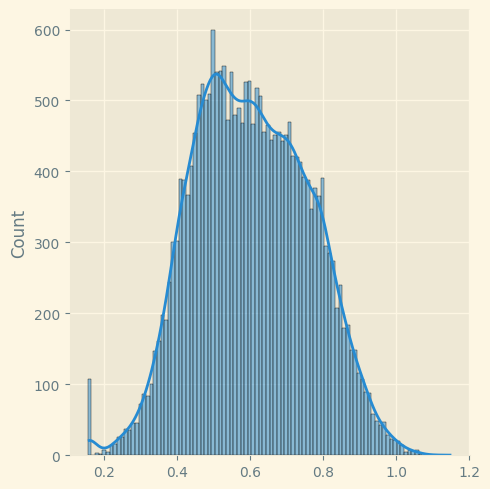

In [184]:
cost_train = np.mean(np.abs(p_train - data_train), axis=1)
sns.displot(cost_train[:,32], bins=100, kde=True)

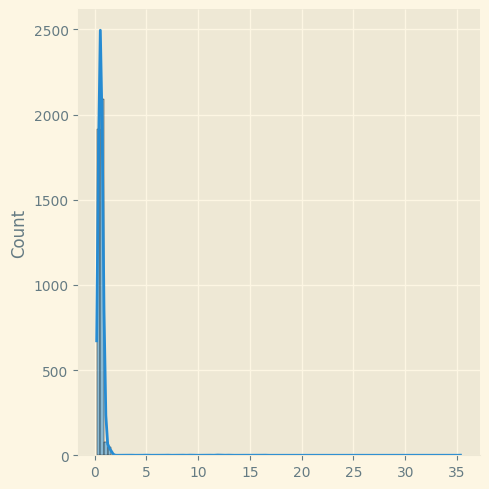

In [185]:
cost_test = np.mean(np.abs(p_test - data_test), axis=1)
sns.displot(cost_test[:,32], bins=100, kde=True)

260/260 [==============================] - 7s 28ms/step
mean: 0.6428241302673501


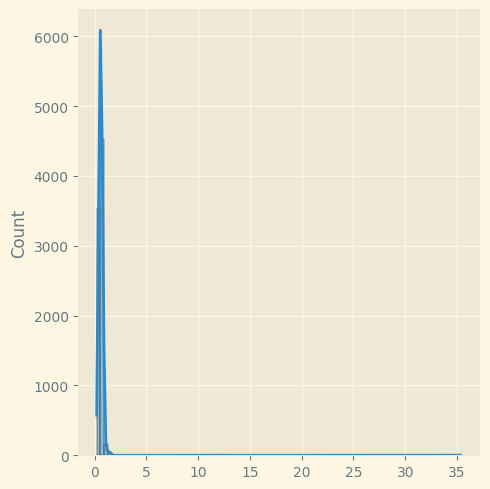

In [186]:
# Prepared test data
p_test_mixed = model.predict(data_test_mixed)

difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
print(f"mean: {np.mean(difference_test_mixed)}")

cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)
sns.displot(cost_test_mixed[:,32], bins=100, kde=True)

In [187]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed

In [58]:
result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

100%|██████████| 829/829 [00:22<00:00, 36.80it/s]

mean F1 score without PA: 0.5529229144230015 
mean F1 score with PA: 0.5569327145159674


In [189]:
result

{'best_f1_wo_pa': 0.6948401771818508,
 'f1_scores': array([6.66666667e-01, 6.66720231e-01, 6.66613098e-01, ...,
        9.63623223e-04, 4.81927711e-04, 0.00000000e+00]),
 'best_precision_wo_pa': 0.6902949571836346,
 'best_recall_wo_pa': 0.6994456495541094,
 'prauc_wo_pa': 0.820171146070078,
 'auc_wo_pa': 0.7565672086668442,
 'raw_f1_w_pa': 0.6666666666666666,
 'raw_precision_w_pa': 0.5,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.6667202313996465,
 'best_f1_th_w_pa': 0.6176282568694217,
 'best_precision_w_pa': 0.5000602627455707,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.6666

## Adversarial Autoencoder - Build Models & Create loss functions

In [42]:
learning_rate_ae = 1e-5
learning_rate_other = 1e-5
max_learning_rate = 2e-5

batch_size = 256

cross_entropy = tf.keras.losses.BinaryCrossentropy() #from_logits=True
mse = tf.keras.losses.MeanSquaredError()

train_dataset = tf.data.Dataset.from_tensor_slices(data_train)
train_dataset = train_dataset.batch(batch_size)

In [43]:
def autoencoder_loss(inputs, reconstruction, loss_weight):
    return loss_weight * mse(inputs, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
    return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

ae_loss_weight = 1.
gen_loss_weight = 0.7
dc_loss_weight = 0.7

In [44]:
def build_model_aae():
    model_enc = build_model_enc()
    model_dec = build_model_dec()
    model_disc = build_model_disc()

    model_ae = Autoencoder(model_enc, model_dec, latent_size)
    model_ae.build(input_shape=(None, input_shape[0], input_shape[1]))

    model_gen = Sequential()
    model_gen.add(model_enc)
    model_gen.add(model_disc)

    return model_enc, model_dec, model_disc, model_ae, model_gen

model_enc, model_dec, model_disc, model_ae, model_gen = build_model_aae()

ae_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_ae)
dc_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_other)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_other)

try:
    with tf.device('/GPU'):
        #data_train = tf.convert_to_tensor(data_train, dtype=tf.int32)

        # discriminator
        model_disc = model_disc
        model_disc.compile(optimizer=dc_optimizer, loss=discriminator_loss)
        model_disc.summary()

        # discriminator encoder pipe (generator)
        model_gen = model_gen
        model_gen.compile(optimizer=gen_optimizer, loss=generator_loss)
        model_gen.summary()

        # auto encoder
        model_ae = model_ae
        model_ae.compile(optimizer=ae_optimizer, loss=autoencoder_loss)
        model_ae.summary()
except RuntimeError as e:
    print(e)


# model_disc.compile(optimizer=Adam(learning_rate=learning_rate_other), loss=cross_entropy)
# model_gen.compile(optimizer=Adam(learning_rate=learning_rate_other), loss=cross_entropy)
# model_ae.compile(optimizer=Adam(learning_rate=learning_rate), loss=mse)

accuracy = tf.keras.metrics.BinaryAccuracy()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 48, 256)           8448      
                                                                 
 dense_28 (Dense)            (None, 48, 128)           32896     
                                                                 
 dense_29 (Dense)            (None, 48, 64)            8256      
                                                                 
 dense_30 (Dense)            (None, 48, 32)            2080      
                                                                 
 dense_31 (Dense)            (None, 48, 1)             33        
                                                                 
Total params: 51,713
Trainable params: 51,713
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_25"
__________________________

In [45]:
comment = False
def train_step(batch_x):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        ae_output = model_ae(batch_x, training=True)

        if comment is True : print(f"Train step: \nbatch_x: {batch_x.shape}, decoder_output: {ae_output.shape}")
        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, ae_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, model_ae.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, model_ae.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], width_window, latent_size], mean=0.0, stddev=1.0)
        encoder_output = model_ae.encoder(batch_x, training=True)

        dc_real = model_disc(real_distribution, training=True)
        dc_fake = model_disc(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, model_disc.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, model_disc.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoded = model_ae.encoder(batch_x, training=True)
        gen_output = model_disc(encoded, training=True)

        # Generator loss
        gen_loss = generator_loss(gen_output, gen_loss_weight)

    gen_grads = gen_tape.gradient(gen_loss, model_ae.encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, model_ae.encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss

In [46]:
n_epochs = 25
train_autoencoder_loss = []
train_generator_loss = []
train_discriminator_loss = []
train_discriminator_acc = []

test_cost = []
train_cost = []
validation_cost = []

n_samples = data_train.shape[0]
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0
for epoch in range(n_epochs):
    start = time.time()

    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()
    for batch, (batch_x) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        # Calculate cyclic learning rate
        # global_step = global_step + 1
        # cycle = np.floor(1 + global_step / (2 * step_size))
        # x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        # clr = learning_rate_ae + (max_learning_rate - learning_rate_ae) * max(0, 1 - x_lr)
        # ae_optimizer.lr = clr
        # dc_optimizer.lr = clr
        # gen_optimizer.lr = clr

        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)

    epoch_time = time.time() - start
    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch+1, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
    train_autoencoder_loss.append(epoch_ae_loss_avg.result())
    train_generator_loss.append(epoch_gen_loss_avg.result())
    train_discriminator_loss.append(epoch_dc_loss_avg.result())
    train_discriminator_acc.append(epoch_dc_acc_avg.result())

    # -------------------------------------------------------------------------------------------------------------
    # train_decoded = model_ae.predict(data_train)
    # cost_train = np.mean(np.abs(train_decoded - data_train), axis=1)
    # train_cost.append(cost_train)
    # print(f"        Mean cost of train: {np.mean(np.abs(train_decoded - data_train))}")
    #
    # test_decoded = model_ae.predict(data_test)
    # cost_test = np.mean(np.abs(test_decoded - data_test), axis=1)
    # test_cost.append(cost_test)
    # print(f"        Mean cost of test: {np.mean(np.abs(test_decoded - data_test))}")
    #
    # val_decoded = model_ae.predict(data_validation)
    # cost_val = np.mean(np.abs(val_decoded - data_validation), axis=1)
    # validation_cost.append(cost_val)
    # print(f"        Mean cost of validation: {np.mean(np.abs(val_decoded - data_validation))}")


   1: TIME: 110.01 ETA: 2750.30 AE_LOSS: 1.3095 DC_LOSS: 1.0102 DC_ACC: 0.4980 GEN_LOSS: 0.3923
   2: TIME: 103.81 ETA: 2491.51 AE_LOSS: 1.2556 DC_LOSS: 1.0346 DC_ACC: 0.4775 GEN_LOSS: 0.3859
   3: TIME: 103.60 ETA: 2382.69 AE_LOSS: 1.2065 DC_LOSS: 0.9943 DC_ACC: 0.4642 GEN_LOSS: 0.4308
   4: TIME: 106.93 ETA: 2352.54 AE_LOSS: 1.1783 DC_LOSS: 0.9537 DC_ACC: 0.4842 GEN_LOSS: 0.4799
   5: TIME: 105.81 ETA: 2222.05 AE_LOSS: 1.1581 DC_LOSS: 0.9479 DC_ACC: 0.5115 GEN_LOSS: 0.4946
   6: TIME: 105.23 ETA: 2104.52 AE_LOSS: 1.1392 DC_LOSS: 0.9461 DC_ACC: 0.5213 GEN_LOSS: 0.5017
   7: TIME: 104.40 ETA: 1983.65 AE_LOSS: 1.1151 DC_LOSS: 0.9300 DC_ACC: 0.5406 GEN_LOSS: 0.5204
   8: TIME: 104.87 ETA: 1887.69 AE_LOSS: 1.0821 DC_LOSS: 0.9257 DC_ACC: 0.5603 GEN_LOSS: 0.5223
   9: TIME: 104.90 ETA: 1783.23 AE_LOSS: 1.0578 DC_LOSS: 0.9268 DC_ACC: 0.5770 GEN_LOSS: 0.5148
  10: TIME: 104.92 ETA: 1678.66 AE_LOSS: 1.0621 DC_LOSS: 0.9690 DC_ACC: 0.5774 GEN_LOSS: 0.4700
  11: TIME: 104.34 ETA: 1565.14 AE_LOSS:

## Losses and Costs during training

In [27]:
test_cost_avg = [np.mean(np.abs(i)) for i in test_cost]
train_cost_avg = [np.mean(np.abs(i)) for i in train_cost]
validation_cost_avg = [np.mean(np.abs(i)) for i in validation_cost]

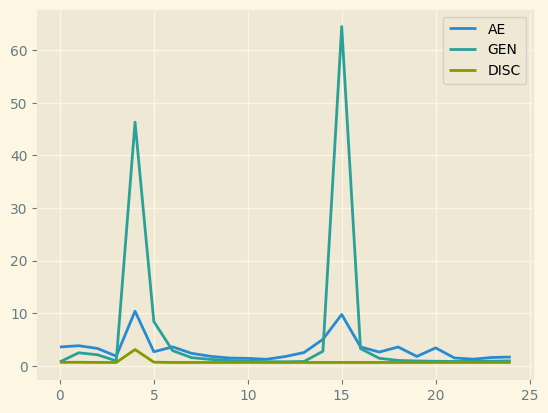

In [100]:
plt.plot(test_cost_avg, label="test")
plt.plot(train_cost_avg, label="train")
plt.plot(validation_cost_avg, label="val")
plt.legend()
plt.show()

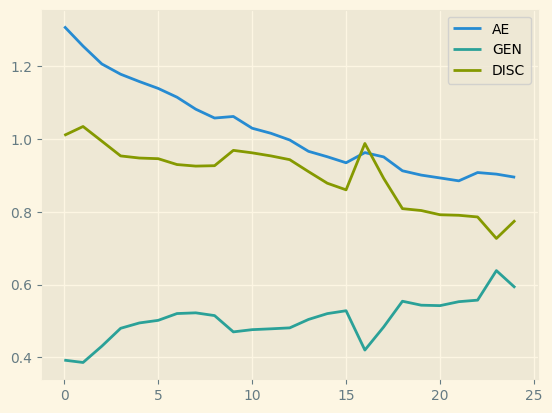

In [55]:
plt.plot(train_autoencoder_loss, label="AE")
plt.plot(train_generator_loss, label="GEN")
plt.plot(train_discriminator_loss, label="DISC")
plt.legend()
plt.show()

In [21]:
def settrainable(model, toset):
    for layer in model.layers:
        layer.trainable = toset
    model.trainable = toset

In [78]:
test_cost = []
train_cost = []
validation_cost = []
total_time = 0

batch_size = 2048
number_epoch = 25
#Set Number of Epochs to 10-20 or higher.
for epoch_number in range(number_epoch):
    start = time.time()

    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()

    for i in range(int(len(data_train) / batch_size)):
        settrainable(model_ae, True)
        settrainable(model_enc, True)
        settrainable(model_dec, True)

        batch = data_train[i*batch_size:i*batch_size+batch_size]
        loss_ae = model_ae.train_on_batch(batch, batch)

        settrainable(model_disc, True)
        batch_pred = model_enc.predict(batch)
        # fake_pred = np.random.standard_gamma(size=(batch_size, width_window, latent_size), shape=(batch_size*width_window*latent_size))
        fake_pred = np.random.standard_normal((batch_size, width_window, latent_size))
        #print(f"fake: {fake_pred.shape}, \nbatch: {batch_pred.shape}")
        disc_batch_x = np.concatenate([batch_pred, fake_pred])
        disc_batch_y = np.concatenate([np.zeros((batch_size, width_window, 1)), np.ones((batch_size, width_window, 1))])
        loss_disc = model_disc.train_on_batch(disc_batch_x, disc_batch_y)
        acc_dc = accuracy(disc_batch_x, loss_disc)

        settrainable(model_gen, True)
        settrainable(model_enc, True)
        settrainable(model_disc, False)
        loss_gen = model_gen.train_on_batch(batch, np.ones((batch_size, width_window, 1)))

        epoch_ae_loss_avg(loss_ae)
        epoch_dc_loss_avg(loss_disc)
        epoch_dc_acc_avg(acc_dc)
        epoch_gen_loss_avg(loss_gen)

    epoch_time = time.time() - start
    total_time += epoch_time

    print ("Reconstruction Loss:", model_ae.evaluate(data_train, data_train, verbose=0))
    print ("Adverserial Loss:", model_gen.evaluate(data_train, np.ones((len(data_train), width_window, 1)), verbose=0))

    print(f"{epoch_number+1} - E_Time: {epoch_time}, T_Time: {total_time}"
          f" \nLosses -> AE: {epoch_ae_loss_avg.result()} - GEN: {epoch_gen_loss_avg.result()} - DISC: {epoch_dc_loss_avg.result()} - DISC_ACC: {epoch_dc_acc_avg.result()} ")

    # Reconstruction cost calculations for each epoch
    # Training
    train_prediction = model_ae.predict(data_train)
    cost_train = np.mean(np.abs(train_prediction - data_train), axis=1)
    train_cost.append(cost_train)

    # Test
    test_prediction = model_ae.predict(data_test)
    cost_test = np.mean(np.abs(test_prediction - data_test), axis=1)
    test_cost.append(cost_test)

    # Validation
    val_prediction = model_ae.predict(data_validation)
    cost_val = np.mean(np.abs(val_prediction - data_validation), axis=1)
    validation_cost.append(cost_val)


    print(f"C_Train: {np.mean(np.abs(train_prediction - data_train))} - C_Test: {np.mean(np.abs(test_prediction - data_test))} - "
          f"C_Val: {np.mean(np.abs(val_prediction - data_validation))}")


64/64 [==============================] - 1s 14ms/step
Reconstruction Loss: 0.6706599593162537
Adverserial Loss: 0.6897854208946228
1 - E_Time: 38.18540382385254, T_Time: 38.18540382385254 
Losses -> AE: 0.6744837164878845 - GEN: 0.7022901773452759 - DISC: 0.7428845763206482 - DISC_ACC: 0.0 
74/74 [==============================] - 2s 26ms/step
C_Train: 0.40927919935885826 - C_Test: 0.5388312959257173 - C_Val: 0.6301730485015036
64/64 [==============================] - 1s 16ms/step
Reconstruction Loss: 0.666695237159729
Adverserial Loss: 0.6611686944961548
2 - E_Time: 35.51827788352966, T_Time: 73.7036817073822 
Losses -> AE: 0.6719744205474854 - GEN: 0.6788604855537415 - DISC: 0.6828345656394958 - DISC_ACC: 1.344877209596973e-09 
74/74 [==============================] - 2s 31ms/step
C_Train: 0.40927919935885826 - C_Test: 2.126895423077173 - C_Val: 0.6316646144962493
64/64 [==============================] - 1s 16ms/step
Reconstruction Loss: 33771.4453125
Adverserial Loss: 0.394470870494

KeyboardInterrupt: 

## Investigation & Evaluation

In [47]:
p_train = model_ae.predict(data_train)
difference_train = np.abs(p_train - data_train)
cost_train = np.mean(np.abs(p_train - data_train), axis=1)
print(f"mean: {np.mean(difference_train)}")


p_test = model_ae.predict(data_test)
difference_test = np.abs(p_test - data_test)
cost_test = np.mean(np.abs(p_test - data_test), axis=1)
print(f"mean: {np.mean(difference_test)}")

731/731 [==============================] - 21s 28ms/step
mean: 0.6580716967582703
130/130 [==============================] - 4s 29ms/step
mean: 0.6852921396824228


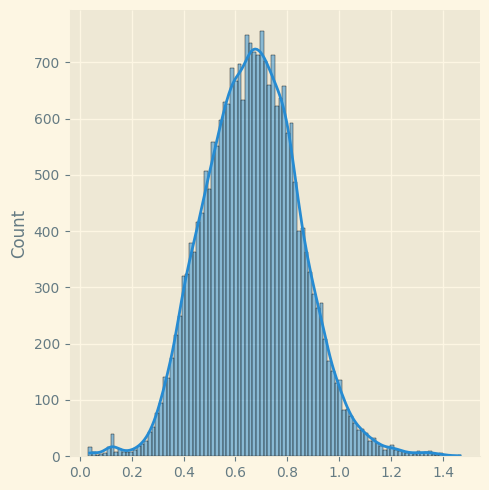

In [48]:
sns.displot(cost_train[:,32], bins=100, kde=True, label="Train")

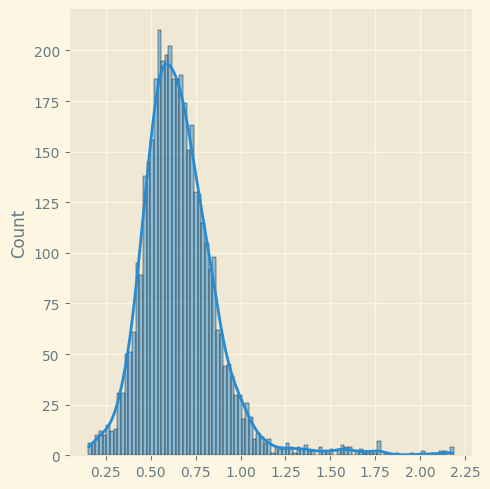

In [49]:
sns.displot(cost_test[:,32], bins=100, kde=True)

260/260 [==============================] - 8s 30ms/step
mean: 0.6690805658830746


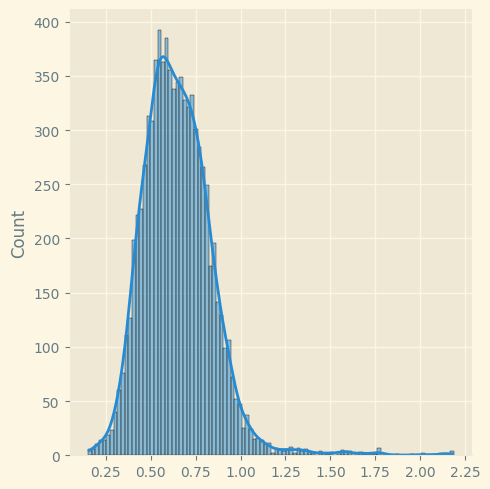

In [50]:
# Prepared test data
p_test_mixed = model_ae.predict(data_test_mixed)

difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
print(f"mean: {np.mean(difference_test_mixed)}")

cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)
sns.displot(cost_test_mixed[:,32], bins=100, kde=True)

### PA%K

In [32]:
def pak(scores, targets, thres, k=20):
    """

    :param scores: anomaly scores
    :param targets: target labels
    :param thres: anomaly threshold
    :param k: PA%K ratio, 0 equals to conventional point adjust and 100 equals to original predictions
    :return: point_adjusted predictions
    """
    scores = np.array(scores)
    thres = np.array(thres)

    predicts = scores > thres
    actuals = targets > 0.01

    one_start_idx = np.where(np.diff(actuals, prepend=0) == 1)[0]
    zero_start_idx = np.where(np.diff(actuals, prepend=0) == 0)[0]

    assert len(one_start_idx) == len(zero_start_idx) + 1 or len(one_start_idx) == len(zero_start_idx)

    if len(one_start_idx) == len(zero_start_idx) + 1:
        zero_start_idx = np.append(zero_start_idx, len(predicts))

    for i in range(len(one_start_idx)):
        if predicts[one_start_idx[i]:zero_start_idx[i]].sum() > k / 100 * (zero_start_idx[i] - one_start_idx[i]):
            predicts[one_start_idx[i]:zero_start_idx[i]] = 1

    return predicts

In [33]:
def evaluate(scores, targets, pa=True, interval=10, k=40):
    """
    :param scores: list or np.array or tensor, anomaly score
    :param targets: list or np.array or tensor, target labels
    :param pa: True/False
    :param interval: threshold search interval
    :param k: PA%K threshold
    :return: results dictionary
    """
    assert len(scores) == len(targets)

    results = {}

    try:
        scores = np.asarray(scores)
        targets = np.asarray(targets)
    except TypeError:
        scores = np.asarray(scores.cpu())
        targets = np.asarray(targets.cpu())

    precision, recall, threshold = metrics.precision_recall_curve(targets, scores)
    f1_score = 2 * precision * recall / (precision + recall + 1e-30)

    #print(f"WITHOUT PA: \nMean precision: {np.mean(precision)} \nMean recall: {np.mean(recall)} \nMean F1 score: {np.mean(f1_score)}")

    results['best_f1_wo_pa'] = np.max(f1_score)
    results['f1_scores'] = f1_score
    results['best_precision_wo_pa'] = precision[np.argmax(f1_score)]
    results['best_recall_wo_pa'] = recall[np.argmax(f1_score)]
    results['prauc_wo_pa'] = metrics.average_precision_score(targets, scores)
    try:
        results['auc_wo_pa'] = metrics.roc_auc_score(targets, scores)
    except ValueError:
        pass


    if pa:
        # find F1 score with optimal threshold of best_f1_wo_pa
        pa_scores = pak(scores, targets, threshold[np.argmax(f1_score)], k)
        results['raw_f1_w_pa'] = metrics.f1_score(targets, pa_scores)
        results['raw_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['raw_recall_w_pa'] = metrics.recall_score(targets, pa_scores)

        # find best F1 score with varying thresholds
        if len(scores) // interval < 1:
            ths = threshold
        else:
            ths = [threshold[interval*i] for i in range(len(threshold)//interval)]
        pa_f1_scores = [metrics.f1_score(targets, pak(scores, targets, th, k)) for th in tqdm(ths)]
        pa_f1_scores = np.asarray(pa_f1_scores)
        results['best_f1_w_pa'] = np.max(pa_f1_scores)
        results['best_f1_th_w_pa'] = ths[np.argmax(pa_f1_scores)]
        pa_scores = pak(scores, targets, ths[np.argmax(pa_f1_scores)], k)
        results['best_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['best_recall_w_pa'] = metrics.recall_score(targets, pa_scores)
        results['pa_f1_scores'] = pa_f1_scores

    return results

In [51]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed

In [52]:
result = evaluate(scores, targets, k=1)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

100%|██████████| 829/829 [00:22<00:00, 36.10it/s]

mean F1 score without PA: 0.5661110009143592 
mean F1 score with PA: 0.6643179470092457


In [54]:
result

{'best_f1_wo_pa': 0.6666666666666666,
 'f1_scores': array([6.66666667e-01, 6.66559537e-01, 6.66452391e-01, ...,
        9.63623223e-04, 4.81927711e-04, 0.00000000e+00]),
 'best_precision_wo_pa': 0.5,
 'best_recall_wo_pa': 1.0,
 'prauc_wo_pa': 0.761594525346937,
 'auc_wo_pa': 0.6979495011124827,
 'raw_f1_w_pa': 0.6666666666666666,
 'raw_precision_w_pa': 0.5,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.6667202313996465,
 'best_f1_th_w_pa': 0.683069339721751,
 'best_precision_w_pa': 0.5000602627455707,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0